In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp

In [38]:
# 엑셀 파일 불러오기
filename = 'WadizTotal2_FSadded.xlsx'
data = pd.read_excel(filename)

In [39]:
# 데이터 쭉 보고 싶으면 호출
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

In [40]:
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace = True)
data.head(1)

,url,제목,메이커,펀딩시작날짜,펀딩마감날짜,펀딩시작요일,목표금액,달성액,달성률,서포터수,좋아요수,요약글,글업데이트수,댓글수,리워드종류수,이미지수,비디오수,배송시작날짜,마감배송차이,인스타존재여부,인스타팔로워수,와디즈팔로워수,과거프로젝트수,과거성공프로젝트수,앵콜펀딩여부,카테고리,디자인소품,반려동물,뷰티,스포츠·모빌리티,여행·레저,테크·가전,패션·잡화,푸드,홈리빙,음절수,단어수,문장수,Strong,Under,가독성,가독성2,제목단어수,펀딩성공여부,분기,PER증감,PBR증감,ROE증감,EBIT증감
0,https://www.wadiz.kr/web/campaign/detail/40364,직접기른 비트와 당근으로 만들어 먹기편한 레드비트즙,오케이네이쳐,2019-08-01,2019-08-11,Thu,500000,803000,160,33,16,공기좋은 영암에서 정성껏 키워 수확 후 저장하지 않고 바로 만든 비트즙입니다 당근이...,0,2,4.0,15.0,0.0,2019-09-19,39,1,0,0,0.0,1.0,0,푸드,0,0,0,0,0,0,0,1,0,1269,707,41,12,1,37.483217,12.315037,6,1,19Q1적용,6.834688,0.084375,-0.600938,317.081549


In [5]:
# 펀딩시작요일- LabelEncoder으로 숫자 타입으로 변환
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
data.펀딩시작요일= le.fit_transform(data.펀딩시작요일)
le.classes_
#0:Fri
#1:Mon
#2:Sat
#3:Sun
#4:Thu
#5:Tue
#6:Wed

array(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype=object)

In [6]:
# 회귀 모델링을 위한 테스트데이터만들기
data.drop(columns=['url','제목','메이커','펀딩시작날짜','펀딩마감날짜','목표금액',
                   '달성액','요약글','배송시작날짜','과거프로젝트수','카테고리','분기',
                  '펀딩성공여부','PER증감','PBR증감','ROE증감','EBIT증감','가독성','가독성2',
                   '음절수','단어수','좋아요수','서포터수','댓글수'], inplace = True)
data.head(1)

,펀딩시작요일,달성률,글업데이트수,리워드종류수,이미지수,비디오수,마감배송차이,인스타존재여부,인스타팔로워수,와디즈팔로워수,과거성공프로젝트수,앵콜펀딩여부,디자인소품,반려동물,뷰티,스포츠·모빌리티,여행·레저,테크·가전,패션·잡화,푸드,홈리빙,문장수,Strong,Under,제목단어수
0,4,160,0,4.0,15.0,0.0,39,1,0,0,1.0,0,0,0,0,0,0,0,0,1,0,41,12,1,6


In [7]:
target= data.달성률
target.head(1)

0    160
Name: 달성률, dtype: int64

In [8]:
wadizdata= data.drop(columns=["달성률"])
wadizdata.head(1)

,펀딩시작요일,글업데이트수,리워드종류수,이미지수,비디오수,마감배송차이,인스타존재여부,인스타팔로워수,와디즈팔로워수,과거성공프로젝트수,앵콜펀딩여부,디자인소품,반려동물,뷰티,스포츠·모빌리티,여행·레저,테크·가전,패션·잡화,푸드,홈리빙,문장수,Strong,Under,제목단어수
0,4,0,4.0,15.0,0.0,39,1,0,0,1.0,0,0,0,0,0,0,0,0,1,0,41,12,1,6


In [9]:
# 학습용/테스트용 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wadizdata,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=100)

In [14]:
#하이퍼 파라미터 튜닝

#rmse
from sklearn.metrics import make_scorer

#예측값(predict)정답(actual)
def rmse(predict, actual):
    
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual
    
    square_distance = distance ** 2
    
    mean_square_distance = square_distance.mean()
    
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_score = make_scorer(rmse)
rmse_score

make_scorer(rmse)

In [16]:
# Coarse
from sklearn.model_selection import cross_val_score

# n_estimators= 트리갯수
# 보통은 높을수록 좋지만, 그만큼 실행 속도가 오래 걸리기 때문에 적당한 값을 설정 (5 개)
# 나머지 하이퍼패리미터가 전부 튜닝되면, 그 다음에는 n_estimators를 최대한 높이 주면 되기때문
n_estimators = 5

# 랜덤 서치를 반복할 횟수(보통 100으로 알고있으나 일단 5)
num_epoch = 5

#criterion= ['gini', 'entropy'] 보통 지니쓰면 될꺼 같아서 안함

# hyperparameter 탐색 결과를 리스트로 저장
coarse_hyperparameters_list = []

# num_epoch 횟수만큼 랜덤 서치를 반복
for epoch in range(num_epoch):
    # 2에서 100 사이의 정수 값을 랜덤하게 생성해서 max_depth 변수에 할당
    max_depth = np.random.randint(low=2, high=100)

    # 0.1에서 1.0 사이의 실수 값을 랜덤하게 생성하여  max_features 변수에 할당
    max_features = np.random.uniform(low=0.1, high=1.0)

    # Random Forest를 생성
    # 1) n_estimators. 트리의 갯수
    # 2) max_depth. 트리의 깊이
    # 3) max_features. Feature Sampling 0.0 ~ 1.0 사이의 값 트리를 생성할 때 전체 feature에서 지정한 비율만큼만 feature를 사용
    
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=100)

    # cross_val_score를 실행
    # 정확도 평균스코어를 스코어로 할당
    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()
    
    # hyperparameter 탐색 결과 딕셔너리화 
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }

    # hyperparameter 탐색 결과 리스트에 저장
    coarse_hyperparameters_list.append(hyperparameters)

    # hyperparameter 탐색 결과 출력
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# coarse_hyperparameters_list를 PDataFrame으로 변환
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# score가 높은 순으로 정렬 - 낮을수록 정확한거(RMSE)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)

# coarse_hyperparameters_list의 상위 10개를 출력
coarse_hyperparameters_list.head(10)

 0 n_estimators = 5, max_depth = 43, max_features = 0.455379, Score = 1949.49415
 1 n_estimators = 5, max_depth =  9, max_features = 0.800802, Score = 1892.12706
 2 n_estimators = 5, max_depth = 64, max_features = 0.579597, Score = 1958.87356
 3 n_estimators = 5, max_depth = 29, max_features = 0.178949, Score = 1930.55685
 4 n_estimators = 5, max_depth = 81, max_features = 0.647808, Score = 1956.99089
(5, 5)


,epoch,max_depth,max_features,n_estimators,score
1,1,9,0.800802,5,1892.127059
3,3,29,0.178949,5,1930.556855
0,0,43,0.455379,5,1949.494151
4,4,81,0.647808,5,1956.990892
2,2,64,0.579597,5,1958.873557


In [17]:
#Finer
n_estimators = 5

num_epoch = 5


finer_hyperparameters_list = []


for epoch in range(num_epoch):
    
    max_depth = np.random.randint(low=1, high=10) # coarse 에서 참고

    
    max_features = np.random.uniform(low=0.15, high=0.9) # coarse 에서 참고 

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=37)

    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()
    
    
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }

    
    finer_hyperparameters_list.append(hyperparameters)

   
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")


finer_hyperparameters_list = pd.DataFrame.from_dict(finer_hyperparameters_list)

finer_hyperparameters_list = finer_hyperparameters_list.sort_values(by="score")


print(finer_hyperparameters_list.shape)

finer_hyperparameters_list.head(10)

 0 n_estimators = 5, max_depth =  6, max_features = 0.670819, Score = 1876.15986
 1 n_estimators = 5, max_depth =  7, max_features = 0.292345, Score = 1858.39683
 2 n_estimators = 5, max_depth =  9, max_features = 0.629709, Score = 1873.35181
 3 n_estimators = 5, max_depth =  4, max_features = 0.223151, Score = 1825.57236
 4 n_estimators = 5, max_depth =  4, max_features = 0.209190, Score = 1825.57236
(5, 5)


,epoch,max_depth,max_features,n_estimators,score
3,3,4,0.223151,5,1825.572359
4,4,4,0.209190,5,1825.572359
1,1,7,0.292345,5,1858.396835
2,2,9,0.629709,5,1873.351808
0,0,6,0.670819,5,1876.159865


In [18]:
# 가장 좋은 정확도가 나온하이퍼패러미터를 가져오기
best_hyperparameters = finer_hyperparameters_list.iloc[0] #0

best_max_depth = best_hyperparameters["max_depth"]

best_max_features = best_hyperparameters["max_features"]

# best_max_depth와 best_max_features를 출력
print(f"max_depth(best) = {best_max_depth}, max_features(best) = {best_max_features:.6f}")

max_depth(best) = 4.0, max_features(best) = 0.223151


In [19]:
# 1) 랜덤포레스트 분류 객체 생성

from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor()
#하이퍼 파라미터튜닝후 n_estimators를 가능한 높은 값주기 (1~5천 천단위..?)
best_n_estimators = 10

rf_reg = RandomForestRegressor(n_estimators=best_n_estimators,
                              max_depth=best_max_depth,
                              max_features=best_max_features,
                              random_state=100,
                              n_jobs=-1)
rf_reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4.0,
                      max_features=0.22315078307074093, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=100, verbose=0,
                      warm_start=False)

In [20]:
# 2) 학습
rf_reg.fit(X_train, y_train)

#실제 예측한 결과값
rf_pred= rf_reg.predict(X_test)

In [21]:
# 3)평가
rf_reg.score(X_test, y_test)

0.1899945226557328

In [13]:
#평가
rf_reg.score(X_test, y_test)

0.21046856488660937

In [22]:
# Grid search cv
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    'n_estimators':range(1,10),
    'max_depth': range(1,10),
    'n_jobs': [-1]
}

In [24]:
grid_rf = GridSearchCV(rf_reg,
                       param_grid = params,
                       cv = 5,
                       n_jobs = -1
                      )

In [25]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=4.0,
                                             max_features=0.22315078307074093,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=-1,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
 

In [26]:
grid_rf.score(X_test, y_test)

0.19373930531571626

In [27]:
grid_rf.best_params_

{'max_depth': 6, 'n_estimators': 7, 'n_jobs': -1}

In [28]:
f_imp = pd.DataFrame(grid_rf.best_estimator_.feature_importances_,
            index = X_train.columns,
            columns = ['importance'])

In [31]:
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')

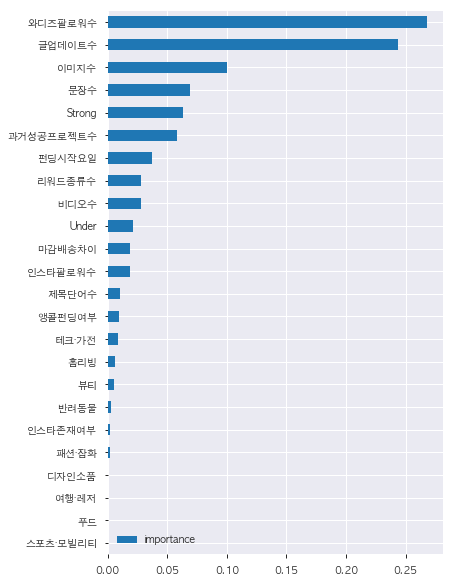

In [32]:
f_imp.sort_values(by= 'importance').\
    plot(kind = 'barh', figsize = (6, 10))